In [1]:
# Imports and setup.
import grasp_opt
import grasp_utils
import mesh_utils
import numpy as np
import pypoisson
import torch
import trimesh

from matplotlib import pyplot as plt
from nerf_shared import config_parser, utils

# Setup config (since we're not running from command line).
parser = config_parser.config_parser()

# Use the teddy_bear config, but change some filepaths.
args = parser.parse_args(args=[
    '--config', 'teddy_bear/config.txt', '--basedir', '.'])#,
    #'--datadir', './nerf_shared/data/nerf_synthetic/teddy_bear'])
# args = parser.parse_args(args=[
#     '--config', './nerf_shared/logs/isaac_teddy4/config.txt', '--basedir', 'nerf_shared/logs',
#     '--datadir', './nerf_shared/data/nerf_synthetic/isaac_teddy'])

# nerf_shared requires us to default to cuda tensors.
torch.set_default_tensor_type(torch.cuda.FloatTensor)

# I <3 autoreload.
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
# Load nerf models, params from checkpoint.
coarse_model, fine_model = utils.create_nerf_models(args)
optimizer = utils.get_optimizer(coarse_model, fine_model, args)
utils.load_checkpoint(coarse_model, fine_model, optimizer, args, checkpoint_index=-1)
images, poses, render_poses, hwf, i_split, K, bds_dict = utils.load_datasets(args)

# Override rendering bounds for fingers.
bds_dict = {'near': 0.05, 'far': 0.15}

renderer = utils.get_renderer(args, bds_dict)
H, W, focal = hwf

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [3]:
# Load ground truth mesh.
if args.config == 'teddy_bear/config.txt':
    gt_mesh = trimesh.load(
        'nerf_shared/data/nerf_synthetic/teddy_bear/bear_demo.glb',
        force='mesh')
    T = trimesh.transformations.euler_matrix(np.pi/2, 0., 0.,'rxyz')
elif args.config == './nerf_shared/logs/isaac_teddy4/config.txt':
    gt_mesh = trimesh.load(
        'nerf_shared/data/nerf_synthetic/isaac_teddy/isaac_bear.obj',
        force='mesh')
    T = trimesh.transformations.scale_matrix(1e-2, np.array([0,0,0]))
gt_mesh.apply_transform(T)
gt_mesh.show()

primitive has no mode! trying GL_TRIANGLES?
primitive has no mode! trying GL_TRIANGLES?
primitive has no mode! trying GL_TRIANGLES?
concatenating texture: may result in visual artifacts


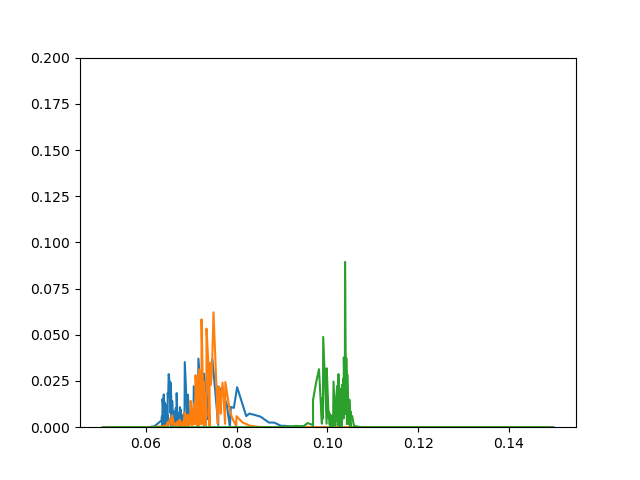

In [55]:
# Test grasp sampling

grasp_points = torch.tensor([[0.09,0.09,-0.025], [-0.09, 0.09, 0.025], [0, -0.125, 0]]).reshape(1, 3, 3)
grasp_dirs = -grasp_points

grasp_vars = torch.cat([grasp_points, grasp_dirs], dim=-1)

rays, weights, z_vals = grasp_utils.get_grasp_distribution(grasp_vars,
                           coarse_model,
                           fine_model,
                           renderer)
plt.close('all')
plt.plot(z_vals[0, :, :].detach().cpu().numpy().T, weights[0,:,:].cpu().detach().numpy().T)
plt.ylim([0, 0.2])
plt.show()

CPU times: user 12.3 ms, sys: 3.23 ms, total: 15.5 ms
Wall time: 15 ms


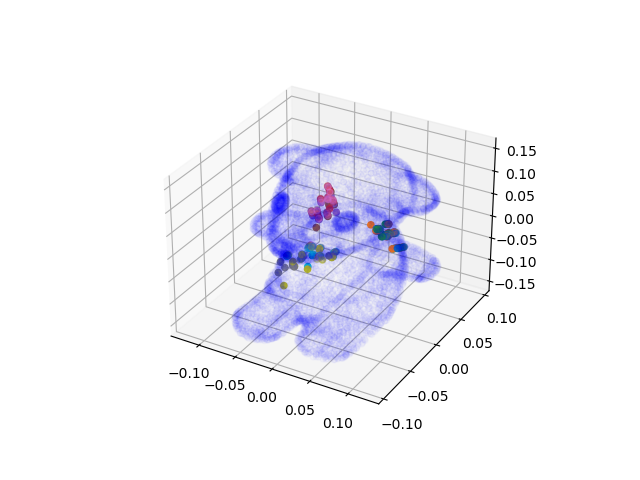

In [56]:
num_grasps = 10
var_batch = grasp_vars + 1e-2 * torch.randn(10, 3, 6)
%time grasp_points, grad_ests, grasp_mask = grasp_utils.sample_grasps(var_batch, \
                                                          num_grasps, \
                                                          coarse_model, \
                                                          fine_model, \
                                                          renderer)

plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

gps_numpy = grasp_points.cpu().detach().numpy().reshape(-1, 3, 3)

for ii in range(gps_numpy.shape[0]):
    ax.scatter(gps_numpy[ii, :, 0], gps_numpy[ii, :, 1], gps_numpy[ii, :, 2])

ax.scatter(*[gt_mesh.triangles_center[:, ii] for ii in range(3)], c='blue', alpha=0.025)

plt.show()

In [104]:
n_f = 3
grasp_points = torch.tensor([[0.09,0.09,-0.025], [-0.09, 0.09, 0.025], [0, -0.125, 0]]).reshape(1, 3, 3)
# grasp_points = 1e-1 * torch.randn(1, 3, 3)
grasp_dirs = -grasp_points

mu_0 = torch.cat([grasp_points, grasp_dirs], dim=-1).reshape(-1)
Sigma_0 = torch.diag(torch.cat([torch.tensor([5e-3, 5e-3, 5e-3, 1e-3, 1e-3, 1e-3]) for _ in range(3)]))

cem_cost = lambda x: grasp_opt.grasp_cost(x, n_f, coarse_model, fine_model, renderer)

with torch.no_grad():
    mu_f, Sigma_f = grasp_opt.optimize_cem(cem_cost, mu_0, Sigma_0, num_iters=50,
                                           elite_frac=.1, num_samples=750)

tensor(-0.0009) tensor(inf)
tensor([0.0065, 0.0056, 0.0040, 0.0026, 0.0024, 0.0022, 0.0020, 0.0019, 0.0014,
        0.0011, 0.0010, 0.0008, 0.0007, 0.0007, 0.0006, 0.0005, 0.0003, 0.0003]) tensor([ 7.9291e-02,  1.0357e-01, -1.9465e-02, -8.9860e-02, -9.3235e-02,
         2.2590e-02, -8.9693e-02,  9.9388e-02,  2.3644e-02,  8.9320e-02,
        -9.5651e-02, -2.4946e-02, -2.2978e-03, -1.1733e-01,  1.0976e-04,
        -1.4973e-03,  1.2259e-01,  3.2923e-03])
tensor(-0.0013) tensor(inf)
tensor([0.0082, 0.0059, 0.0047, 0.0034, 0.0024, 0.0019, 0.0016, 0.0013, 0.0013,
        0.0010, 0.0009, 0.0007, 0.0005, 0.0004, 0.0003, 0.0003, 0.0002, 0.0002]) tensor([ 0.0911,  0.1047, -0.0392, -0.0951, -0.0955,  0.0220, -0.1017,  0.1037,
         0.0075,  0.0834, -0.0985, -0.0133, -0.0069, -0.1146, -0.0052, -0.0044,
         0.1341,  0.0049])
tensor(-0.0010) tensor(inf)
tensor([0.0098, 0.0048, 0.0040, 0.0033, 0.0020, 0.0018, 0.0016, 0.0012, 0.0010,
        0.0010, 0.0007, 0.0006, 0.0004, 0.0003, 0.0002, 0.00

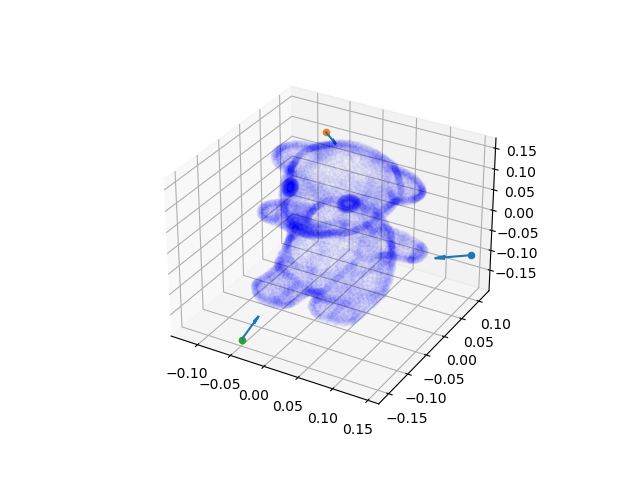

In [105]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

gps_numpy = mu_f.cpu().detach().numpy().reshape(3, 6)

for ii in range(gps_numpy.shape[0]):
    ax.scatter(gps_numpy[ii, 0], gps_numpy[ii, 1], gps_numpy[ii, 2])
    ax.quiver(*[gps_numpy[ii, jj] for jj in range(6)],
          length=0.05, normalize=True)

ax.scatter(*[gt_mesh.triangles_center[:, ii] for ii in range(3)], c='blue', alpha=0.025)

plt.show()

CPU times: user 14.8 ms, sys: 0 ns, total: 14.8 ms
Wall time: 14.1 ms


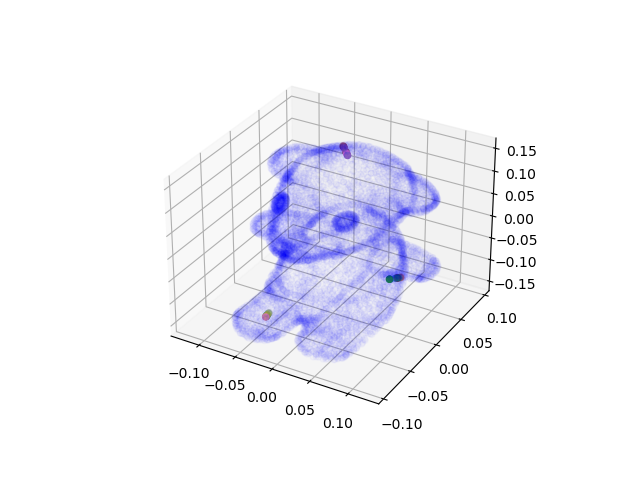

In [106]:
# Sample some grasps + visualize
# n = mu_f.shape[0]
# num_samples = 25
# x = (mu_f.reshape(1, n, 1)
#                  + torch.linalg.cholesky(Sigma_f).reshape(1, n, n)
#                  @ torch.randn(num_samples, n, 1)).reshape(num_samples, n)
# x = x.reshape(-1, n_f, 6)
x = mu_f.reshape(-1, n_f, 6)
%time grasp_points, grad_ests, grasp_mask = grasp_utils.sample_grasps(x, \
                                                          num_grasps, \
                                                          coarse_model, \
                                                          fine_model, \
                                                          renderer)


plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

gps_numpy = grasp_points.cpu().detach().numpy().reshape(-1, 3, 3)

for ii in range(gps_numpy.shape[0]):
    ax.scatter(gps_numpy[ii, :, 0], gps_numpy[ii, :, 1], gps_numpy[ii, :, 2])

ax.scatter(*[gt_mesh.triangles_center[:, ii] for ii in range(3)], c='blue', alpha=0.025)

plt.show()

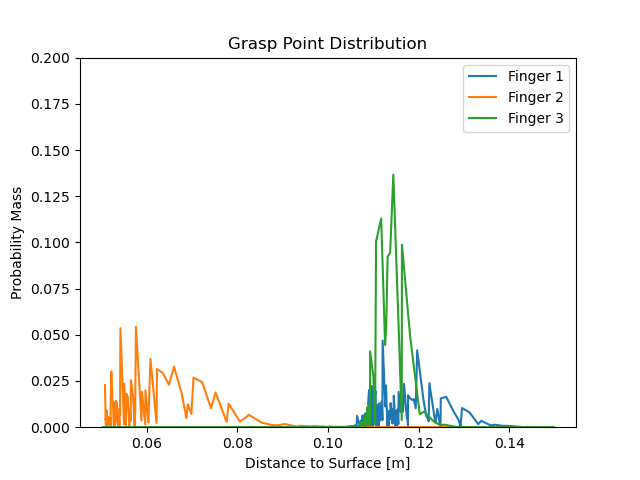

In [118]:
# Test grasp sampling

rays, weights, z_vals = grasp_utils.get_grasp_distribution(mu_f.reshape(1,3,6),
                           coarse_model,
                           fine_model,
                           renderer)
plt.close('all')
for ii in range(3):
    plt.plot(z_vals[0, ii, :].detach().cpu().numpy().T, weights[0,ii,:].cpu().detach().numpy().T,
             label="Finger "+str(ii+1))
plt.ylim([0, 0.2])
plt.title("Grasp Point Distribution")
plt.xlabel("Distance to Surface [m]")
plt.ylabel("Probability Mass")
plt.legend()
plt.show()

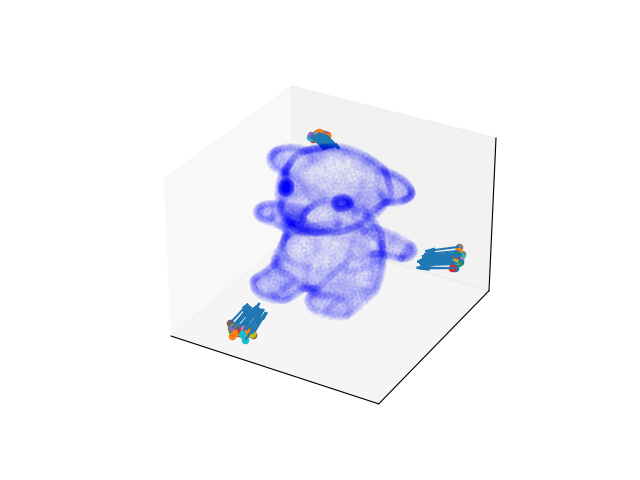

In [112]:
# Visualize point/normal distribution
n = mu_f.shape[0]
num_samples = 25
x = (mu_f.reshape(1, n, 1)
                 + torch.linalg.cholesky(Sigma_f).reshape(1, n, n)
                 @ torch.randn(num_samples, n, 1)).reshape(num_samples, n)
x = x.reshape(-1, n_f, 6)

plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

gps_numpy = x.cpu().detach().numpy().reshape(-1, 3, 6)

for bb in range(num_samples):
    for ii in range(3):
        ax.scatter(gps_numpy[bb, ii, 0], gps_numpy[bb, ii, 1], gps_numpy[bb, ii, 2])
        ax.quiver(*[gps_numpy[bb, ii, jj] for jj in range(6)],
              length=0.05, normalize=True)

ax.scatter(*[gt_mesh.triangles_center[:, ii] for ii in range(3)], c='blue', alpha=0.025)
# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()